In [1]:
# Import necessary packages
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn. compose import ColumnTransformer 
from sklearn.metrics import *

In [2]:
df = pd.read_csv('data_nlp.csv')

In [3]:
df = df[['lem_text','y']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lem_text  11144 non-null  object
 1   y         11144 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 174.2+ KB


In [4]:
df['y'].value_counts(normalize=True)

0    0.506281
1    0.493719
Name: y, dtype: float64

In [5]:
y = df['y']
X = df.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
seed = np.random.seed(42)

In [7]:
# Initialze the estimators
clf1 = RandomForestClassifier(random_state = seed)
clf2 = SVC(random_state =seed)
clf3_0 = LogisticRegression(solver = 'saga',random_state =seed)
clf3_1 = LogisticRegression(random_state =seed)
clf4 = DecisionTreeClassifier(random_state =seed)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()
clf7 = GradientBoostingClassifier(random_state =seed)

In [8]:
# Moodels with CountVectorizer

# Setting up a Pipeline with CountVectorizer (Transformer) and Classifiers (Estimators)
text_preprocessing = Pipeline([('Vect', CountVectorizer())])

preprocess = ColumnTransformer([
                            ('text_preprocessing', text_preprocessing, 'lem_text')
                        ])
                        
pipe = Pipeline([
    ('pre', preprocess),
    ('classifier', clf1)
])

#pipe.get_params()

In [9]:
# Moodels with TfidfVectorizer

# Setting up a Pipeline with TfidfVectorizer (Transformer) and Classifiers (Estimators)
text_preprocessing = Pipeline([('Vect', TfidfVectorizer())])

preprocess = ColumnTransformer([
                            ('text_preprocessing', text_preprocessing, 'lem_text')
                        ])
                        
pipe_tfidf = Pipeline([
    ('pre', preprocess),
    ('classifier', clf1)
])

In [10]:
# Initiaze the dictionary of hyperparameters  

# NLP
pre = {
    'pre__text_preprocessing__Vect__max_features': [1000, 2000, 3000, 3500, 4000],
    'pre__text_preprocessing__Vect__stop_words': ['english'],
    'pre__text_preprocessing__Vect__max_df': [0.5, 0.7, 0.9],
    'pre__text_preprocessing__Vect__min_df': [1, 2, 3],
    'pre__text_preprocessing__Vect__ngram_range': [(1,1), (1,2)]
    }

# Random Forest
param1 = copy.deepcopy(pre)
param1['classifier'] = [clf1]
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]

# SVC
param2 = copy.deepcopy(pre)
param2['classifier'] = [clf2]
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2, 10e5]
param2['classifier__gamma'] = [0.0001, 0.001, 0.01, 0.1, 1, 10, 'auto']

# Logistic Regression
param3_0 = copy.deepcopy(pre)
param3_0['classifier'] = [clf3_0]
param3_0['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3_0['classifier__penalty'] = ['none', 'l1', 'l2', 'elasticnet']

# Logistic Regression (l2 only)
param3_1 = copy.deepcopy(pre)
param3_1['classifier'] = [clf3_1]
param3_1['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3_1['classifier__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param3_1['classifier__penalty'] = ['none', 'l2']

# Decision Tree
param4 = copy.deepcopy(pre)
param4['classifier'] = [clf4]
param4['classifier__max_depth'] = [5,15,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__min_samples_leaf'] =[1,2,3,4,5]
param4['classifier__ccp_alpha'] =[0,10**-1, 10**0, 10**1, 10**2]

# KNN
param5 = copy.deepcopy(pre)
param5['classifier'] = [clf5]
param5['classifier__n_neighbors'] = range(1, 51, 5)
param5['classifier__weights']= ['uniform', 'distance']
param5['classifier__metric']= ['euclidean', 'manhattan','minkowski']

# Multinomial Naive Bayers
param6 = copy.deepcopy(pre)
param6['classifier'] = [clf6]
param6['classifier__alpha'] = [10**0, 10**1, 10**2]

# Gradient Boosting
param7 = copy.deepcopy(pre)
param7['classifier'] = [clf7]
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]

params = [param1, param2, param3_0, param3_1, param4, param5, param6, param7]


### CountVectorizer Model 1 :  optimize roc_auc

In [11]:
%%time
# Train the randomized search models
rs1 = RandomizedSearchCV(pipe, params, cv=3, n_jobs=-1, random_state =42, scoring='roc_auc').fit(X_train, y_train)

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

CPU times: user 1.41 s, sys: 449 ms, total: 1.86 s
Wall time: 16.2 s


In [12]:
print('Best CV score:',rs1.best_score_)
print('Best Model parameters:',rs1.best_params_)
print('Train score:',rs1.score(X_train,y_train))
print('Test score:',rs1.score(X_test,y_test))
print(classification_report(y_test,
                            rs1.predict(X_test)))

Best CV score: 0.8783190232473382
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9624934801406164
Test score: 0.8875529430711007
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.79      0.83      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229



[[885 244]
 [187 913]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


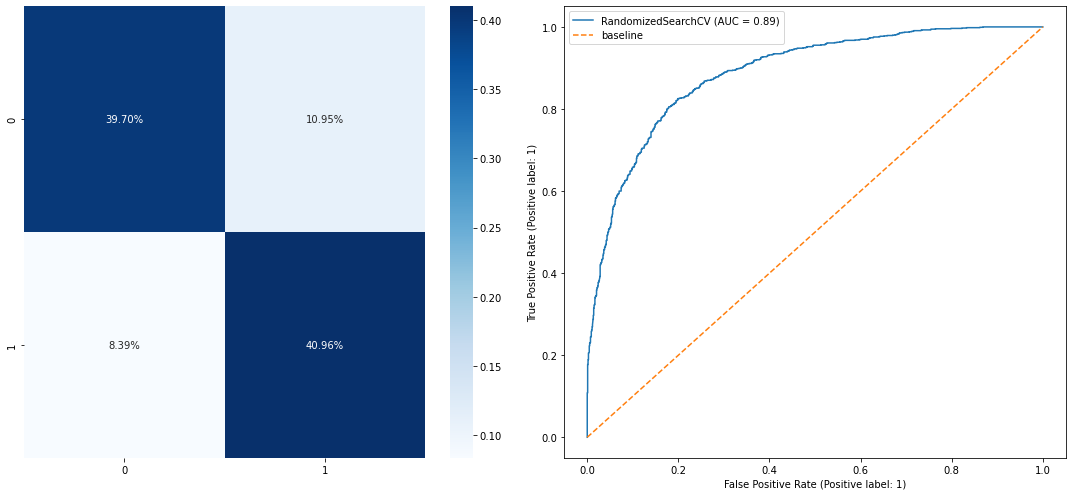

In [13]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

y_pred = rs1.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax0)
plot_roc_curve(rs1, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

In [14]:
#pd.DataFrame(rs1.cv_results_).iloc[[0]]
#rs1.best_params_.items()

### TfidfVectorizer Model 1 :  optimize roc_auc

In [15]:
%%time
# Train the randomized search models 
s1 = RandomizedSearchCV(pipe_tfidf, params, cv=3, n_jobs=-1, scoring='roc_auc', random_state =30).fit(X_train, y_train)

CPU times: user 3.82 s, sys: 491 ms, total: 4.31 s
Wall time: 39 s


In [16]:
print('Best CV score:',s1.best_score_)
print('Best Model parameters:',s1.best_params_)
print('Train score:',s1.score(X_train,y_train))
print('Test score:',s1.score(X_test,y_test))
print(classification_report(y_test,s1.predict(X_test)))

Best CV score: 0.883568109166777
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 2), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.5, 'classifier__n_estimators': 100, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20)}
Train score: 0.9712375163757826
Test score: 0.8873923021177228
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.84      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229



[[874 255]
 [177 923]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


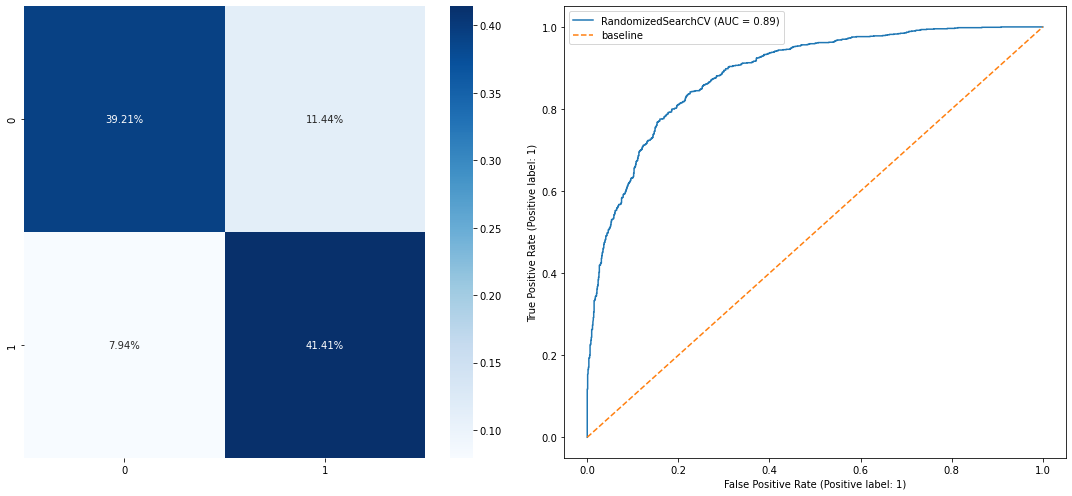

In [17]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = s1.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(s1, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

### CountVectorizer Model 2 :  Optimize Accuracy

In [18]:
%%time
# Train the randomized search models
rs2 = RandomizedSearchCV(pipe, params, cv=3, n_jobs=-1, scoring='accuracy', random_state =42).fit(X_train, y_train)

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

CPU times: user 1.31 s, sys: 319 ms, total: 1.63 s
Wall time: 12.7 s


In [19]:
print('Best CV score:',rs2.best_score_)
print('Best Model parameters:',rs2.best_params_)
print('Train score:',rs2.score(X_train,y_train))
print('Test score:',rs2.score(X_test,y_test))
print(classification_report(y_test, rs2.predict(X_test)))

Best CV score: 0.790241551386749
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8846887268648346
Test score: 0.7994616419919246
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1129
           1       0.78      0.83      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229



[[874 255]
 [192 908]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


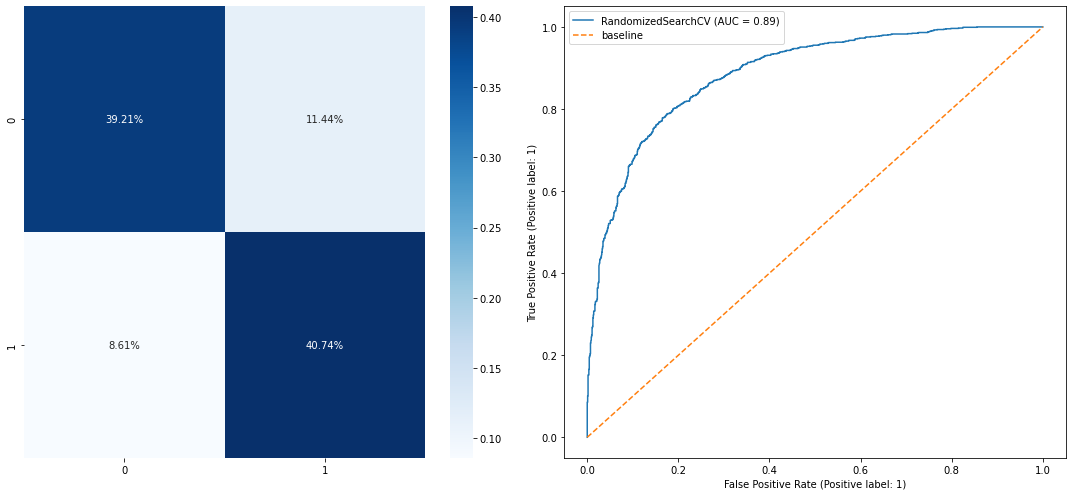

In [20]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

y_pred = rs2.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax0)
plot_roc_curve(rs2, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

### TfidfVectorizer Model 2 :  Optimize Accuracy

In [21]:
%%time
# Train the randomized search models
s2 = RandomizedSearchCV(pipe_tfidf, params, cv=3, n_jobs=-1, scoring='accuracy', random_state =46).fit(X_train, y_train)

CPU times: user 852 ms, sys: 309 ms, total: 1.16 s
Wall time: 14.7 s


In [22]:
print('Best CV score:',s2.best_score_)
print('Best Model parameters:',s2.best_params_)
print('Train score:',s2.score(X_train,y_train))
print('Test score:',s2.score(X_test,y_test))
print(classification_report(y_test,s2.predict(X_test)))

Best CV score: 0.793046367616132
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 2000, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__penalty': 'l2', 'classifier__C': 0.1, 'classifier': LogisticRegression(C=0.1, solver='saga')}
Train score: 0.8176107683679192
Test score: 0.7985643786451323
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1129
           1       0.78      0.82      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229



[[880 249]
 [200 900]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


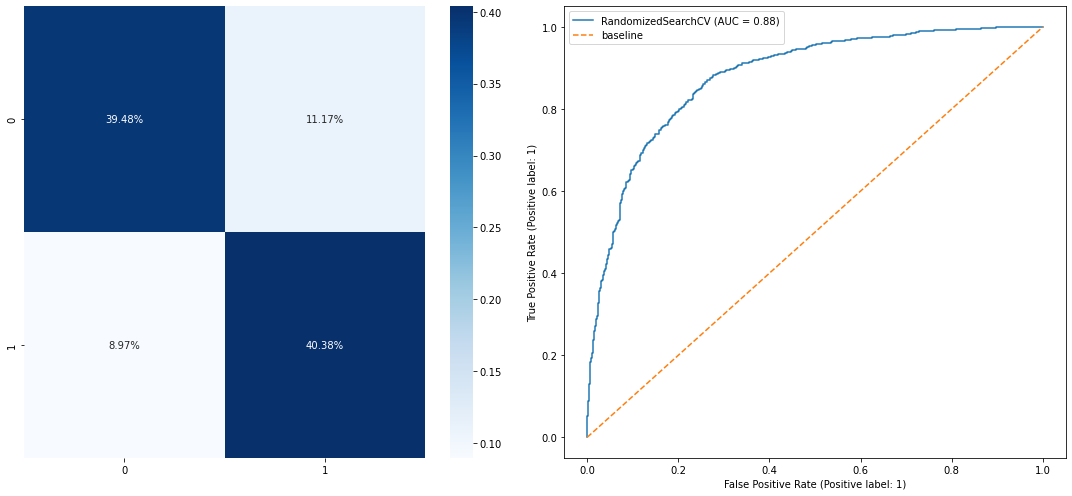

In [23]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = s2.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(s2, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

In [24]:
accuracy1 = accuracy_score(y_test,rs2.predict(X_test))
precision1 = precision_score(y_test,rs2.predict(X_test))
recall1 = recall_score(y_test,rs2.predict(X_test))
accuracy2 = accuracy_score(y_test,s2.predict(X_test))
precision2 = precision_score(y_test,s2.predict(X_test))
recall2 = recall_score(y_test,s2.predict(X_test))

pd.DataFrame([[accuracy1, precision1,recall1],[accuracy2, precision2,recall2]], columns=['accuracy','precision','recall'])

,accuracy,precision,recall
0,0.799462,0.780739,0.825455
1,0.798564,0.783290,0.818182


### CountVectorizer Model 3 :  Optimize f1

In [25]:
%%time
# Train the randomized search models
rs3 = RandomizedSearchCV(pipe, params, cv=3, n_jobs=-1, random_state = 42, scoring='f1').fit(X_train, y_train)

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

CPU times: user 1.35 s, sys: 319 ms, total: 1.67 s
Wall time: 14.6 s


In [26]:
print('Best CV score:',rs3.best_score_)
print('Best Model parameters:',rs3.best_params_)
print('Train score:',rs3.score(X_train,y_train))
print('Test score:',rs3.score(X_test,y_test))
print(classification_report(y_test,
                            rs3.predict(X_test)))

Best CV score: 0.7961005401552983
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.896410034602076
Test score: 0.810978308986277
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1129
           1       0.79      0.83      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229



[[886 243]
 [184 916]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


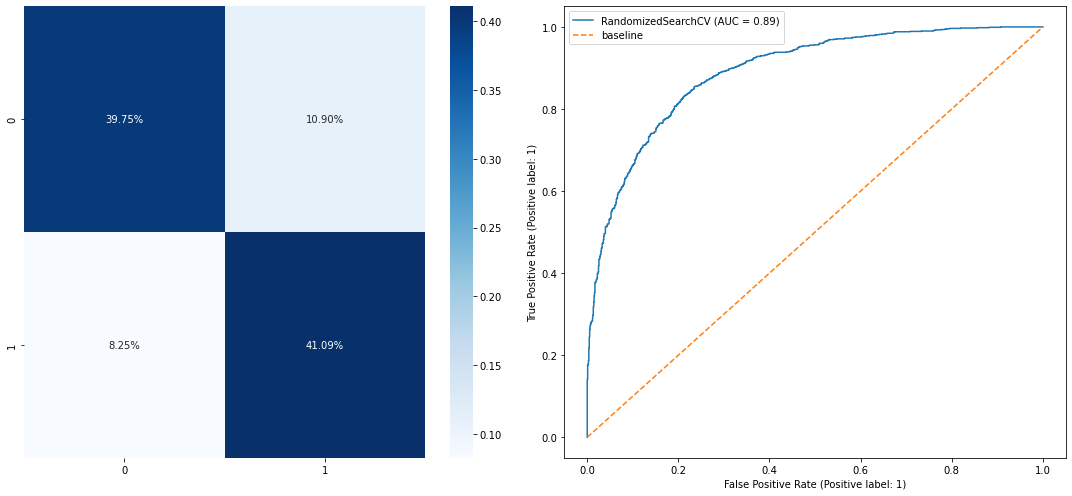

In [27]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = rs3.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(rs3, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

### TfidfVectorizer Model 3 :  Optimize f1

In [28]:
%%time
# Train the randomized search models
s3 = RandomizedSearchCV(pipe_tfidf, params, cv=3, n_jobs=-1, scoring='f1', random_state =46).fit(X_train, y_train)

CPU times: user 854 ms, sys: 308 ms, total: 1.16 s
Wall time: 15.2 s


In [29]:
print('Best CV score:',s3.best_score_)
print('Best Model parameters:',s3.best_params_)
print('Train score:',s3.score(X_train,y_train))
print('Test score:',s3.score(X_test,y_test))
print(classification_report(y_test,s3.predict(X_test)))

Best CV score: 0.7973256977477385
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 2000, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__penalty': 'l2', 'classifier__C': 0.1, 'classifier': LogisticRegression(C=0.1, solver='saga')}
Train score: 0.8207443294428539
Test score: 0.8003557136505114
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1129
           1       0.78      0.82      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229



[[880 249]
 [200 900]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


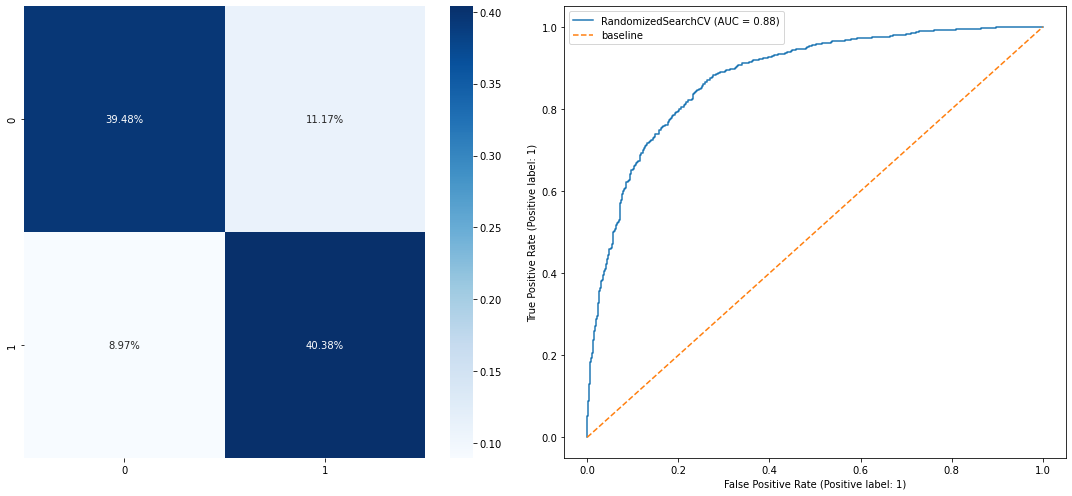

In [30]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = s3.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(s3, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

### Building a Model that has higher weight to precision

The Metric to train data : F-beta

![](2022-11-10-20-50-44.png)

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).

In [31]:
def Train_beta(list_beta):   
    result=[]
    for i in list_beta:
        f_beta = make_scorer(fbeta_score, beta=i)
        
        # Train the randomized search models
        rs_fbeta = RandomizedSearchCV(pipe, params, cv=5, n_jobs=-1, scoring=f_beta, random_state = 42).fit(X_train, y_train)

        # Print result for each model
        print(f'Training Result for beta={i}')
        print('*' * 50)
        print('Best CV score:',rs_fbeta.best_score_)
        print('Best Model parameters:',rs_fbeta.best_params_)
        print('Train score:',rs_fbeta.score(X_train,y_train))
        print('Test score:',rs_fbeta.score(X_test,y_test))
        print(classification_report(y_test,rs_fbeta.predict(X_test)))
        print('*' * 50)

        # Scoring of test data
        accuracy = accuracy_score(y_test,rs_fbeta.predict(X_test))
        precision = precision_score(y_test,rs_fbeta.predict(X_test))
        recall = recall_score(y_test,rs_fbeta.predict(X_test))
        f_beta = fbeta_score(y_test,rs_fbeta.predict(X_test), beta=i)

        # Save metrics and model information to dataframe
        df = pd.DataFrame([[rs_fbeta.best_params_['classifier'],i,accuracy,precision,recall,f_beta,rs_fbeta.score(X_train,y_train),rs_fbeta.score(X_test,y_test)]], \
            columns=['classifier','beta','accuracy','precision','recall','f_beta','train_score','test_score'])

        # Save result for each model
        result.append(df)

    return result

In [32]:
# Train multiple models based on various f beta scoring. 
# it takes 10+ mins to run
rsb = Train_beta([ 1.01, 1.1, 1.15, 1.2, 1.3, 1.5, 2, 3.5, 5, 10, 25, 50])

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.01
**************************************************
Best CV score: 0.7992479232466548
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8924017208060526
Test score: 0.8093913013572016
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1129
           1       0.77      0.85      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.81      0.80      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.1
**************************************************
Best CV score: 0.8029115066286667
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8950705870573706
Test score: 0.8066719681908548
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1129
           1       0.78      0.83      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.15
**************************************************
Best CV score: 0.8021711582963016
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8984819459972788
Test score: 0.8113614308819331
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.83      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.81      0.80      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.2
**************************************************
Best CV score: 0.8040420998685317
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.899152384634108
Test score: 0.8136287686160554
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.79      0.83      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.3
**************************************************
Best CV score: 0.8087225595335246
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9037157516691917
Test score: 0.8171592775041051
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.84      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.81      0.80      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.5
**************************************************
Best CV score: 0.8070604649845036
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9093971091026032
Test score: 0.8127230304693933
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1129
           1       0.78      0.83      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=2
**************************************************
Best CV score: 0.8325178652213208
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 4000, 'pre__text_preprocessing__Vect__max_df': 0.5, 'classifier__weights': 'distance', 'classifier__n_neighbors': 21, 'classifier__metric': 'euclidean', 'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=21, weights='distance')}
Train score: 1.0
Test score: 0.8383233532934132
              precision    recall  f1-score   support

           0       0.87      0.22      0.35      1129
           1       0.55      0.97      0.70      1100

    accuracy                           0.59      2229
   macro avg       0.71      0.59      0.52      2229
weighted avg       0.71      0.59      0.52      2229

*******************************************

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=3.5
**************************************************
Best CV score: 0.9120959043967094
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 3, 'pre__text_preprocessing__Vect__max_features': 4000, 'pre__text_preprocessing__Vect__max_df': 0.9, 'classifier__weights': 'distance', 'classifier__n_neighbors': 46, 'classifier__metric': 'euclidean', 'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=46, weights='distance')}
Train score: 1.0
Test score: 0.9115163085684701
              precision    recall  f1-score   support

           0       0.85      0.19      0.31      1129
           1       0.54      0.97      0.69      1100

    accuracy                           0.57      2229
   macro avg       0.70      0.58      0.50      2229
weighted avg       0.70      0.57      0.50      2229

*****************************************

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=5
**************************************************
Best CV score: 0.9390842598047169
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 3, 'pre__text_preprocessing__Vect__max_features': 4000, 'pre__text_preprocessing__Vect__max_df': 0.9, 'classifier__weights': 'distance', 'classifier__n_neighbors': 46, 'classifier__metric': 'euclidean', 'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=46, weights='distance')}
Train score: 1.0
Test score: 0.937612375750585
              precision    recall  f1-score   support

           0       0.85      0.19      0.31      1129
           1       0.54      0.97      0.69      1100

    accuracy                           0.57      2229
   macro avg       0.70      0.58      0.50      2229
weighted avg       0.70      0.57      0.50      2229

********************************************

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=10
**************************************************
Best CV score: 0.9610285592080764
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 3, 'pre__text_preprocessing__Vect__max_features': 4000, 'pre__text_preprocessing__Vect__max_df': 0.9, 'classifier__weights': 'distance', 'classifier__n_neighbors': 46, 'classifier__metric': 'euclidean', 'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=46, weights='distance')}
Train score: 1.0
Test score: 0.9587951097100297
              precision    recall  f1-score   support

           0       0.85      0.19      0.31      1129
           1       0.54      0.97      0.69      1100

    accuracy                           0.57      2229
   macro avg       0.70      0.58      0.50      2229
weighted avg       0.70      0.57      0.50      2229

******************************************

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=25
**************************************************
Best CV score: 0.9676023133048985
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 3, 'pre__text_preprocessing__Vect__max_features': 4000, 'pre__text_preprocessing__Vect__max_df': 0.9, 'classifier__weights': 'distance', 'classifier__n_neighbors': 46, 'classifier__metric': 'euclidean', 'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=46, weights='distance')}
Train score: 1.0
Test score: 0.9651344424832156
              precision    recall  f1-score   support

           0       0.85      0.19      0.31      1129
           1       0.54      0.97      0.69      1100

    accuracy                           0.57      2229
   macro avg       0.70      0.58      0.50      2229
weighted avg       0.70      0.57      0.50      2229

******************************************

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=50
**************************************************
Best CV score: 0.9685578623988438
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 3, 'pre__text_preprocessing__Vect__max_features': 4000, 'pre__text_preprocessing__Vect__max_df': 0.9, 'classifier__weights': 'distance', 'classifier__n_neighbors': 46, 'classifier__metric': 'euclidean', 'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=46, weights='distance')}
Train score: 1.0
Test score: 0.9660556756106607
              precision    recall  f1-score   support

           0       0.85      0.19      0.31      1129
           1       0.54      0.97      0.69      1100

    accuracy                           0.57      2229
   macro avg       0.70      0.58      0.50      2229
weighted avg       0.70      0.57      0.50      2229

******************************************

In [33]:
met = pd.concat(rsb).reset_index(drop=True)
# Model scoring for each beta
met

,classifier,beta,accuracy,precision,recall,f_beta,train_score,test_score
0,"RandomForestClassifier(max_depth=20, n_estimat...",1.01,0.802602,0.774086,0.847273,0.809391,0.892402,0.809391
1,"RandomForestClassifier(max_depth=20, n_estimat...",1.10,0.799013,0.775338,0.834545,0.806672,0.895071,0.806672
2,"RandomForestClassifier(max_depth=20, n_estimat...",1.15,0.803948,0.782609,0.834545,0.811361,0.898482,0.811361
3,"RandomForestClassifier(max_depth=20, n_estimat...",1.20,0.805742,0.785287,0.834545,0.813629,0.899152,0.813629
4,"RandomForestClassifier(max_depth=20, n_estimat...",1.30,0.804397,0.779933,0.840909,0.817159,0.903716,0.817159
5,"RandomForestClassifier(max_depth=20, n_estimat...",1.50,0.799910,0.779966,0.828182,0.812723,0.909397,0.812723
6,"KNeighborsClassifier(metric='euclidean', n_nei...",2.00,0.588156,0.546763,0.967273,0.838323,1.000000,0.838323
7,"KNeighborsClassifier(metric='euclidean', n_nei...",3.50,0.573351,0.537683,0.966364,0.911516,1.000000,0.911516
8,"KNeighborsClassifier(metric='euclidean', n_nei...",5.00,0.573351,0.537683,0.966364,0.937612,1.000000,0.937612
9,"KNeighborsClassifier(metric='euclidean', n_nei...",10.00,0.573351,0.537683,0.966364,0.958795,1.000000,0.958795


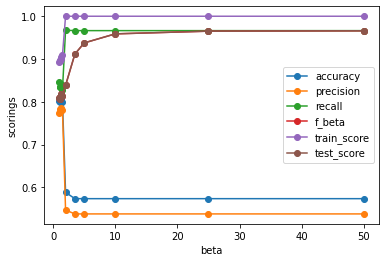

In [34]:
# create figures to visualize scoring change
fig,ax=plt.subplots()

ax.plot(met.beta, met.accuracy, marker="o",label="accuracy")
ax.plot(met.beta, met.precision, marker="o",label="precision")
ax.plot(met.beta, met.recall, marker="o",label="recall")
ax.plot(met.beta, met.f_beta, marker="o",label="f_beta")
ax.plot(met.beta, met.train_score, marker="o",label="train_score")
ax.plot(met.beta, met.test_score, marker="o",label="test_score")

ax.set_xlabel("beta")
ax.set_ylabel("scorings")
ax.legend()

plt.show()

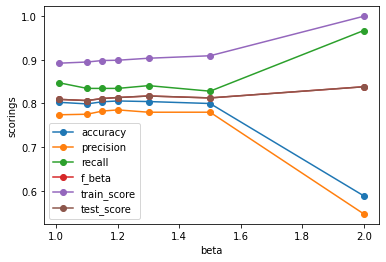

In [35]:
# A better visialization to see the drop of acccuracy
met=met.iloc[:7,:]
fig,ax=plt.subplots()

ax.plot(met.beta, met.accuracy, marker="o",label="accuracy")
ax.plot(met.beta, met.precision, marker="o",label="precision")
ax.plot(met.beta, met.recall, marker="o",label="recall")
ax.plot(met.beta, met.f_beta, marker="o",label="f_beta")
ax.plot(met.beta, met.train_score, marker="o",label="train_score")
ax.plot(met.beta, met.test_score, marker="o",label="test_score")

ax.set_xlabel("beta")
ax.set_ylabel("scorings")
ax.legend()

plt.show()

we found the when beta >= 1.5, the best model turns to KNN and the model accuracy drops significantly. Thus, to maitain accuracy while improving recall, we try to tune the beta between 1 and 1.5.

In [36]:
# Train multiple models based on various f beta scoring. 
# it takes 10+ mins to run
rsb1 = Train_beta([ 1,  1.009, 1.014, 1.023, 1.03, 1.035, 1.04, 1.045, 1.05, 1.07, 1.09, 1.11, 1.12, 1.128, 1.136, 1.14, 1.15, 1.18, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55])

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1
**************************************************
Best CV score: 0.800233989468204
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8913582910777861
Test score: 0.8070640176600441
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.78      0.83      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.009
**************************************************
Best CV score: 0.8024684249711477
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.888627699440486
Test score: 0.8056865033303748
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1129
           1       0.78      0.83      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.014
**************************************************
Best CV score: 0.8008021919760978
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8910579501801151
Test score: 0.8031883077393411
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1129
           1       0.78      0.83      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.023
**************************************************
Best CV score: 0.7976344713444826
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8930122991313123
Test score: 0.8067585312223432
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.83      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.03
**************************************************
Best CV score: 0.8000589589735488
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.891565947380581
Test score: 0.8105592552995077
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.79      0.83      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.035
**************************************************
Best CV score: 0.7999727965706537
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8922303046316873
Test score: 0.8121248024855653
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.79      0.84      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.04
**************************************************
Best CV score: 0.799885499562895
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8917566095168821
Test score: 0.8032889222066991
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1129
           1       0.78      0.82      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.045
**************************************************
Best CV score: 0.8034435649670948
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8948172749933284
Test score: 0.8095677796501387
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.78      0.83      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.81      0.81      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.05
**************************************************
Best CV score: 0.8011004016837167
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8922131196038776
Test score: 0.8079937205651491
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.83      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.07
**************************************************
Best CV score: 0.7995619719010889
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8888344065107312
Test score: 0.8116677371450545
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.84      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.81      0.81      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.09
**************************************************
Best CV score: 0.8028875890853675
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8969283045055093
Test score: 0.802273288986953
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1129
           1       0.79      0.82      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.11
**************************************************
Best CV score: 0.8011581983222266
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8974188787279579
Test score: 0.8168246453046417
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1129
           1       0.79      0.84      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.12
**************************************************
Best CV score: 0.8011883144225663
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8928922523980323
Test score: 0.806323639540689
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1129
           1       0.77      0.83      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.128
**************************************************
Best CV score: 0.8038790093078172
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8988145929794195
Test score: 0.8052518535741685
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1129
           1       0.78      0.83      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.136
**************************************************
Best CV score: 0.8023201643113735
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.895708451099008
Test score: 0.8151496576732641
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.79      0.84      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.14
**************************************************
Best CV score: 0.802563751344907
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8960068954403243
Test score: 0.8004217016410669
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1129
           1       0.78      0.82      0.80      1100

    accuracy                           0.79      2229
   macro avg       0.80      0.80      0.79      2229
weighted avg       0.80      0.79      0.79      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.15
**************************************************
Best CV score: 0.8050504587589016
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8920339238046532
Test score: 0.8130390956194066
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1129
           1       0.77      0.84      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.18
**************************************************
Best CV score: 0.8026087817202884
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8977200642045702
Test score: 0.8156191479574424
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1129
           1       0.79      0.84      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.2
**************************************************
Best CV score: 0.8072069651332443
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9023616913034442
Test score: 0.8115536105032822
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1129
           1       0.79      0.83      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.25
**************************************************
Best CV score: 0.8076635240459762
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9003106676704166
Test score: 0.8129584879606456
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.84      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.3
**************************************************
Best CV score: 0.8054763656527009
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.910669433220487
Test score: 0.8054852600198743
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1129
           1       0.78      0.82      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.35
**************************************************
Best CV score: 0.804620440330608
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9044819897236586
Test score: 0.8225558779703553
              precision    recall  f1-score   support

           0       0.84      0.78      0.80      1129
           1       0.79      0.84      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.4
**************************************************
Best CV score: 0.8090633361630216
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9079754601226995
Test score: 0.8159374059584713
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.78      0.83      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.81      0.81      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.45
**************************************************
Best CV score: 0.8070273139996564
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.909513825787427
Test score: 0.8186998784933172
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1129
           1       0.78      0.84      0.81      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.81      0.80      0.80      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.5
**************************************************
Best CV score: 0.8111333959159086
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9092189674484913
Test score: 0.8171939477303989
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.79      0.83      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

Training Result for beta=1.55
**************************************************
Best CV score: 0.8112419871133083
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9133663390376247
Test score: 0.8173690781260268
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1129
           1       0.79      0.83      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229

**************************************************


In [37]:
met1 = pd.concat(rsb1).reset_index(drop=True)
# Model scoring for each beta
met1

,classifier,beta,accuracy,precision,recall,f_beta,train_score,test_score
0,"RandomForestClassifier(max_depth=20, n_estimat...",1.000,0.803948,0.784549,0.830909,0.807064,0.891358,0.807064
1,"RandomForestClassifier(max_depth=20, n_estimat...",1.009,0.801705,0.780717,0.831818,0.805687,0.888628,0.805687
2,"RandomForestClassifier(max_depth=20, n_estimat...",1.014,0.798564,0.776551,0.830909,0.803188,0.891058,0.803188
3,"RandomForestClassifier(max_depth=20, n_estimat...",1.023,0.802153,0.780426,0.833636,0.806759,0.893012,0.806759
4,"RandomForestClassifier(max_depth=20, n_estimat...",1.030,0.807088,0.788296,0.832727,0.810559,0.891566,0.810559
5,"RandomForestClassifier(max_depth=20, n_estimat...",1.035,0.807986,0.787671,0.836364,0.812125,0.892230,0.812125
6,"RandomForestClassifier(max_depth=20, n_estimat...",1.040,0.799910,0.782383,0.823636,0.803289,0.891757,0.803289
7,"RandomForestClassifier(max_depth=20, n_estimat...",1.045,0.804845,0.783945,0.834545,0.809568,0.894817,0.809568
8,"RandomForestClassifier(max_depth=20, n_estimat...",1.050,0.802602,0.780612,0.834545,0.807994,0.892213,0.807994
9,"RandomForestClassifier(max_depth=20, n_estimat...",1.070,0.804845,0.780591,0.840909,0.811668,0.888834,0.811668


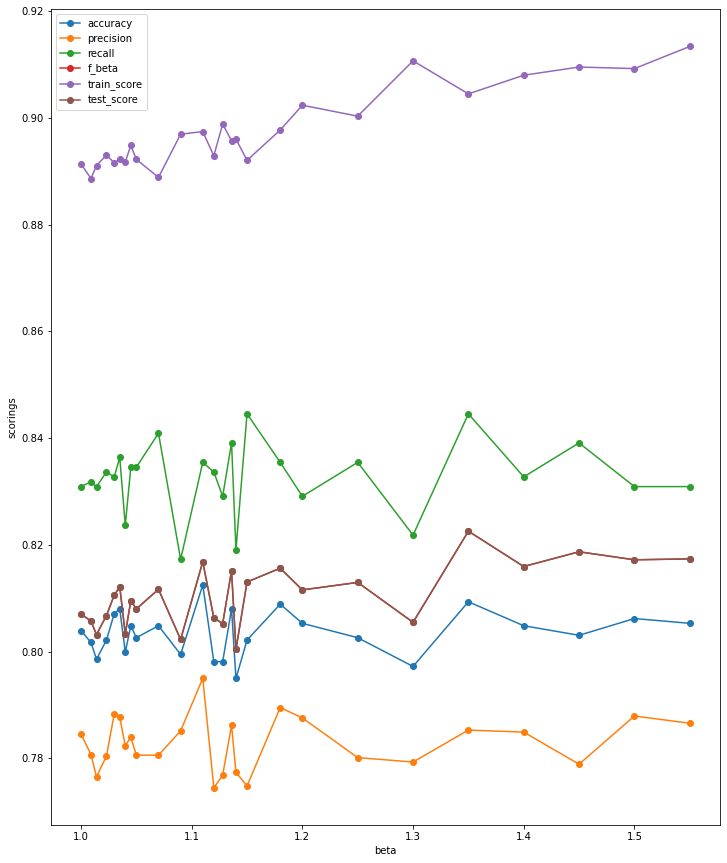

In [73]:
fig,ax=plt.subplots(figsize=(12, 15))

ax.plot(met1.beta, met1.accuracy, marker="o",label="accuracy")
ax.plot(met1.beta, met1.precision, marker="o",label="precision")
ax.plot(met1.beta, met1.recall, marker="o",label="recall")
ax.plot(met1.beta, met1.f_beta, marker="o",label="f_beta")
ax.plot(met1.beta, met1.train_score, marker="o",label="train_score")
ax.plot(met1.beta, met1.test_score, marker="o",label="test_score")

ax.set_xlabel("beta")
ax.set_ylabel("scorings")
ax.legend()

plt.show()

We can see when beta=1.11, the accuracy didn't drop much but accuracy increased. So I will use f beta scoring with beta=1.11 to train model

### CountVectorizer Model 4 :  Optimize f beta (beta = 1.11)

In [39]:
f_beta = make_scorer(fbeta_score, beta=1.11)
        
# Train the randomized search models
rs4 = RandomizedSearchCV(pipe, params, cv=5, n_jobs=-1, scoring=f_beta, random_state = 42).fit(X_train, y_train)

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

In [40]:
print('Best CV score:',rs4.best_score_)
print('Best Model parameters:',rs4.best_params_)
print('Train score:',rs4.score(X_train,y_train))
print('Test score:',rs4.score(X_test,y_test))
print(classification_report(y_test,rs4.predict(X_test)))

Best CV score: 0.8015117758886732
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.8953255739853813
Test score: 0.8080604097886522
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1129
           1       0.78      0.84      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229



[[863 266]
 [180 920]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


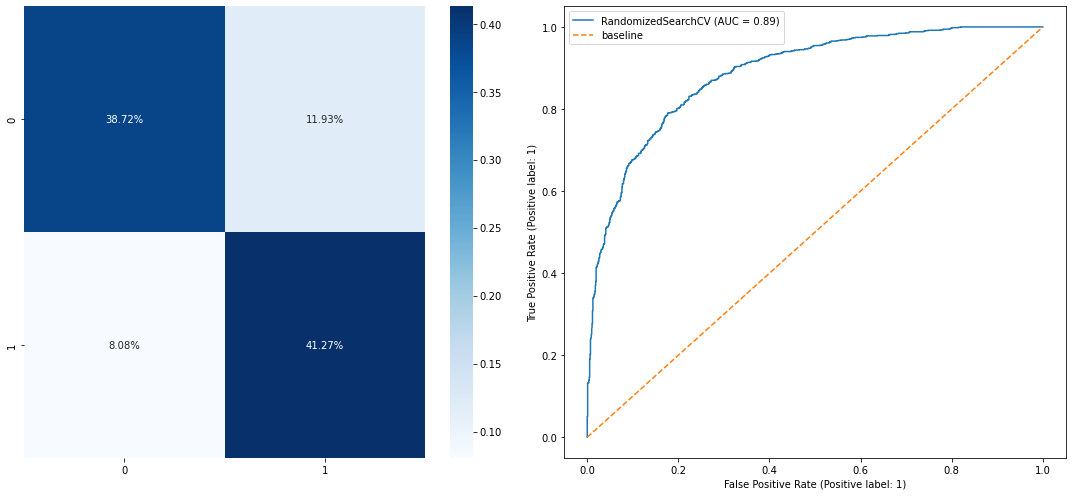

In [41]:

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = rs4.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(rs4, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

### TfidfVectorizer Model 4 :  Optimize f beta (beta = 1.11)

In [42]:
s4 = RandomizedSearchCV(pipe_tfidf, params, cv=5, n_jobs=-1, scoring=f_beta, random_state = 42).fit(X_train, y_train)

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1

In [43]:
print('Best CV score:',s4.best_score_)
print('Best Model parameters:',s4.best_params_)
print('Train score:',s4.score(X_train,y_train))
print('Test score:',s4.score(X_test,y_test))
print(classification_report(y_test,s4.predict(X_test)))

Best CV score: 0.8032524920274646
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 1), 'pre__text_preprocessing__Vect__min_df': 2, 'pre__text_preprocessing__Vect__max_features': 3500, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(max_depth=20, n_estimators=50)}
Train score: 0.9136893298393877
Test score: 0.8070132199928242
              precision    recall  f1-score   support

           0       0.83      0.77      0.79      1129
           1       0.78      0.83      0.80      1100

    accuracy                           0.80      2229
   macro avg       0.80      0.80      0.80      2229
weighted avg       0.80      0.80      0.80      2229



[[865 264]
 [183 917]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


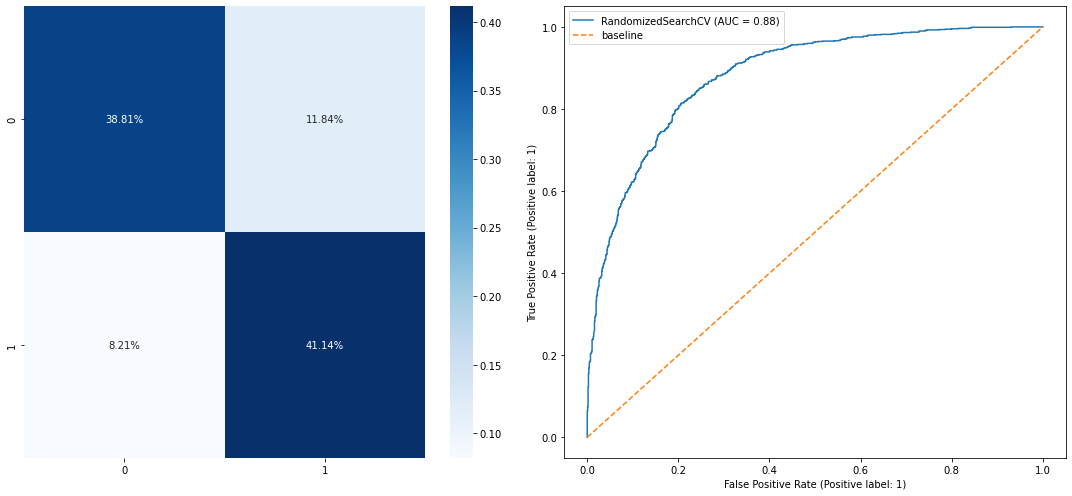

In [44]:

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = s4.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(s4, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

### Trying to get more training result with different randomized seed

In [67]:
%%time
# Train the randomized search models
s = RandomizedSearchCV(pipe, params, cv=3, n_jobs=-1, scoring='roc_auc',random_state=0).fit(X_train, y_train)

CPU times: user 18.4 s, sys: 727 ms, total: 19.2 s
Wall time: 57.7 s


In [68]:
print('Best CV score:',s.best_score_)
print('Best Model parameters:',s.best_params_)
print('Train score:',s.score(X_train,y_train))
print('Test score:',s.score(X_test,y_test))

Best CV score: 0.8878727778942945
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 2), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 3000, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier': GradientBoostingClassifier(max_depth=10)}
Train score: 0.9897908389847171
Test score: 0.8961329414606651


[[911 218]
 [203 897]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


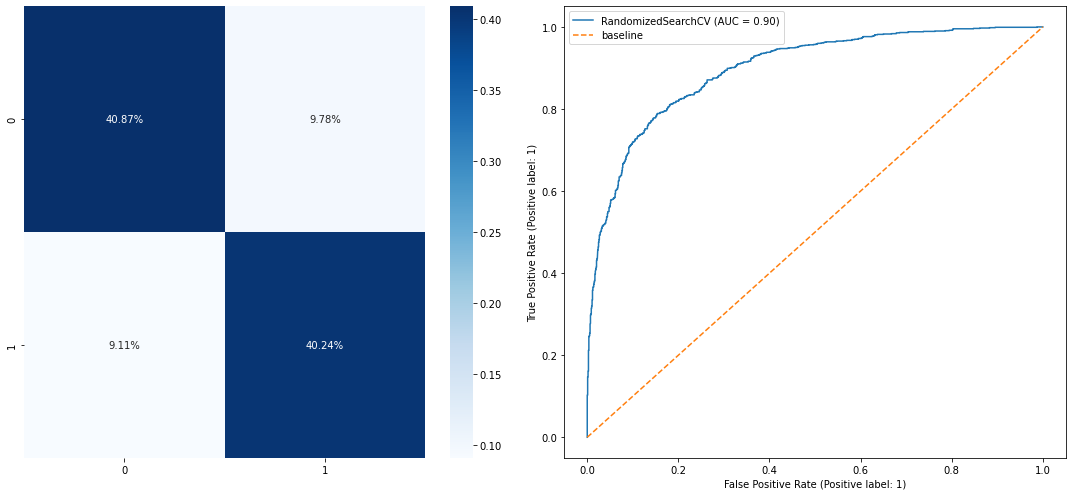

In [70]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = s.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(s, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

In [49]:
%%time
# Train the randomized search models
s01 = RandomizedSearchCV(pipe_tfidf, params, cv=3, n_jobs=-1, scoring='roc_auc',random_state=0).fit(X_train, y_train)

CPU times: user 35.5 s, sys: 753 ms, total: 36.2 s
Wall time: 1min 19s


In [50]:
print('Best CV score:',s01.best_score_)
print('Best Model parameters:',s01.best_params_)
print('Train score:',s01.score(X_train,y_train))
print('Test score:',s01.score(X_test,y_test))

Best CV score: 0.8853451310200747
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 2), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 3000, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier': GradientBoostingClassifier(max_depth=10)}
Train score: 0.9968700396341006
Test score: 0.8905608342056526


[[905 224]
 [200 900]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


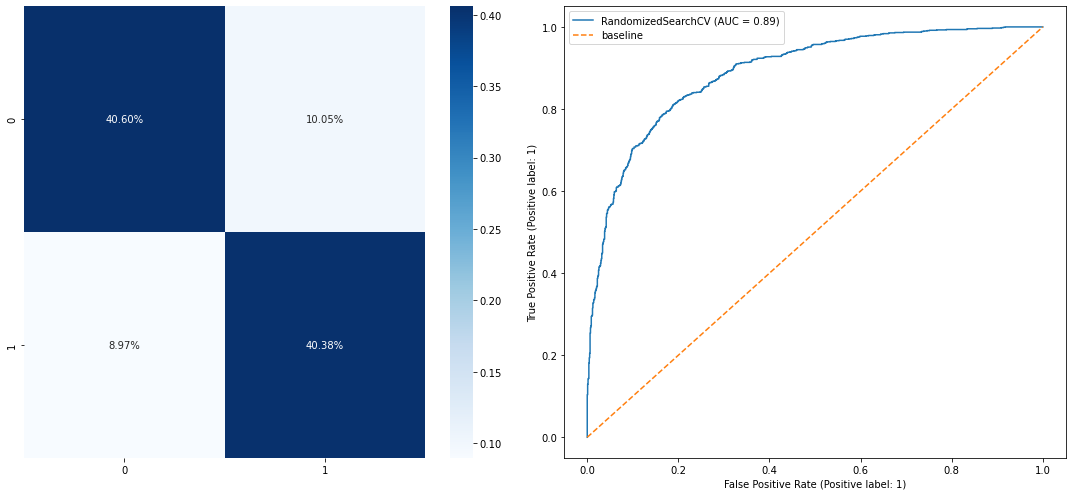

In [80]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = s01.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(s01, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

In [77]:
f_beta = make_scorer(fbeta_score, beta=1.11)

In [78]:
# Train the randomized search models
r1 = RandomizedSearchCV(pipe, params, cv=5, n_jobs=-1, scoring=f_beta, random_state = 0).fit(X_train, y_train)

In [79]:
print('Best CV score:',r1.best_score_)
print('Best Model parameters:',r1.best_params_)
print('Train score:',r1.score(X_train,y_train))
print('Test score:',r1.score(X_test,y_test))
print(classification_report(y_test,r1.predict(X_test)))

Best CV score: 0.812640963899215
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 2), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 3000, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier': GradientBoostingClassifier(max_depth=10)}
Train score: 0.9503631245561655
Test score: 0.8108349762731271
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1129
           1       0.80      0.82      0.81      1100

    accuracy                           0.81      2229
   macro avg       0.81      0.81      0.81      2229
weighted avg       0.81      0.81      0.81      2229



[[892 237]
 [187 913]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


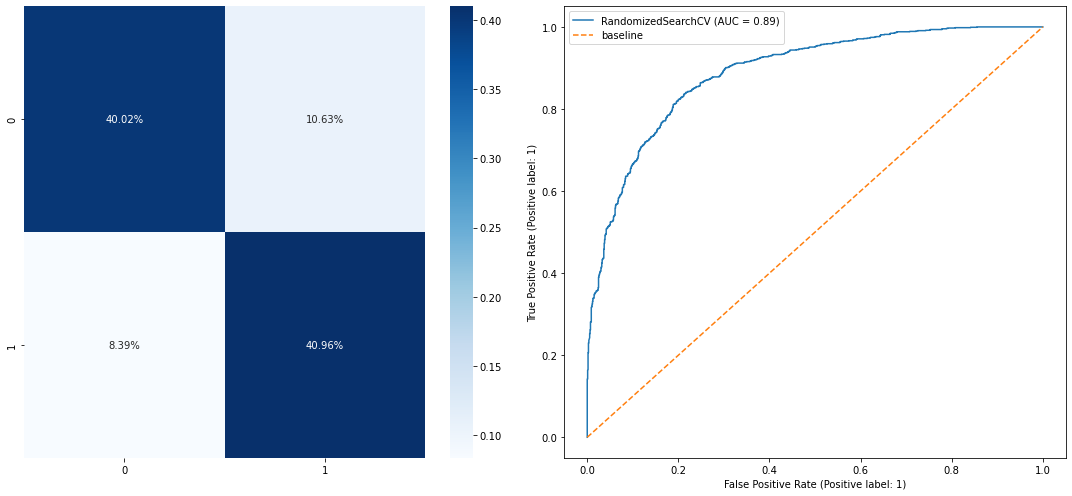

In [55]:

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = r1.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(r1, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

In [81]:
# Train the randomized search models
r2 = RandomizedSearchCV(pipe, params, cv=5, n_jobs=-1, scoring="accuracy", random_state = 0).fit(X_train, y_train)

In [82]:
print('Best CV score:',r2.best_score_)
print('Best Model parameters:',r2.best_params_)
print('Train score:',r2.score(X_train,y_train))
print('Test score:',r2.score(X_test,y_test))
print(classification_report(y_test,r2.predict(X_test)))

Best CV score: 0.8079641054402693
Best Model parameters: {'pre__text_preprocessing__Vect__stop_words': 'english', 'pre__text_preprocessing__Vect__ngram_range': (1, 2), 'pre__text_preprocessing__Vect__min_df': 1, 'pre__text_preprocessing__Vect__max_features': 3000, 'pre__text_preprocessing__Vect__max_df': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier': GradientBoostingClassifier(max_depth=10)}
Train score: 0.9458216489063377
Test score: 0.816509645580978
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1129
           1       0.81      0.82      0.82      1100

    accuracy                           0.82      2229
   macro avg       0.82      0.82      0.82      2229
weighted avg       0.82      0.82      0.82      2229



[[914 215]
 [194 906]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


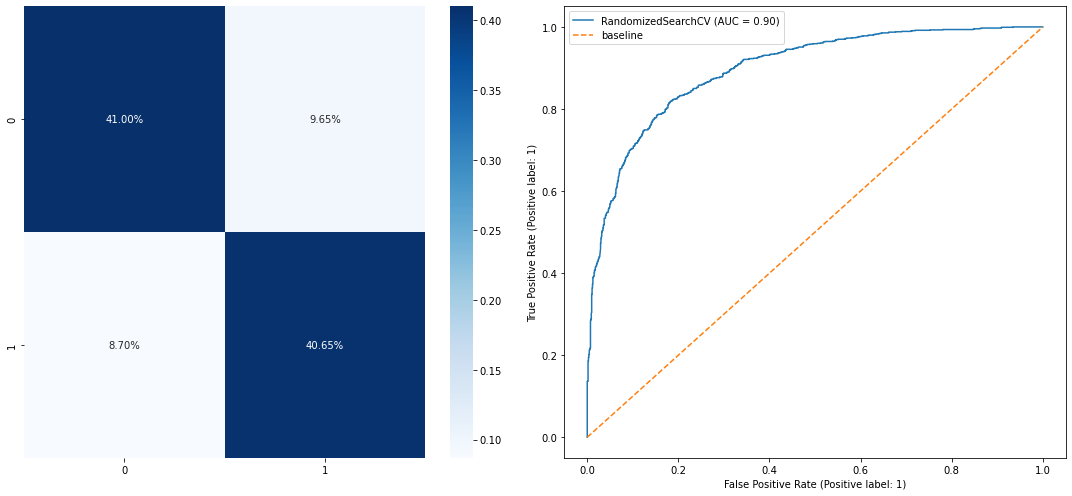

In [83]:

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = r2.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(r2, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

### Traing Result Consolidation

In [84]:
# Consolidate all the best model from each training batch into a result dataframe

l=[]  
best_model_list = [s1,s2,s3,s4,rs1,rs2,rs3,rs4,s,s01,r1,r2]
model_name= ['s1','s2','s3','s4','rs1','rs2','rs3','rs4','s','s01','r1','r2']
model_dict = {k:v for k,v in zip(model_name,best_model_list)}
for model_name in model_dict.keys():  
    model = model_dict[model_name]
    # Scoring of test data
    accuracy = accuracy_score(y_test,model.predict(X_test))
    precision = precision_score(y_test,model.predict(X_test))
    recall = recall_score(y_test,model.predict(X_test))
    f_beta = fbeta_score(y_test,model.predict(X_test), beta=1.11)

    # Save model params to dataframe df_p
    header = pd.DataFrame(model.best_params_.items()).T.iloc[0]
    df_p = pd.DataFrame(model.best_params_.items()).T[1:]
    df_p.columns = header
    df_p = df_p.reset_index(drop=True)

    # Save metrics to dataframe df_m
    df_m = pd.DataFrame([[model_name, model, accuracy,precision,recall,f_beta,model.score(X_train,y_train),model.score(X_test,y_test)]], \
        columns=['model name','model','accuracy','precision','recall','f_beta','train_score','test_score'])
    
    # Merge two dataframe
    df = pd.concat([df_p, df_m], axis=1)

    # Save result for each model
    l.append(df)

# convert to dataframe
result_df = pd.concat(l).reset_index(drop=True)
result_df

,pre__text_preprocessing__Vect__stop_words,pre__text_preprocessing__Vect__ngram_range,pre__text_preprocessing__Vect__min_df,pre__text_preprocessing__Vect__max_features,pre__text_preprocessing__Vect__max_df,classifier__n_estimators,classifier__max_depth,classifier,model name,model,accuracy,precision,recall,f_beta,train_score,test_score,classifier__penalty,classifier__C
0,english,"(1, 2)",1,3500,0.5,100,20,"RandomForestClassifier(max_depth=20, n_estimat...",s1,"RandomizedSearchCV(cv=3,\n e...",0.806191,0.783531,0.839091,0.813256,0.971238,0.887392,NaN,NaN
1,english,"(1, 1)",1,2000,0.7,NaN,NaN,"LogisticRegression(C=0.1, solver='saga')",s2,"RandomizedSearchCV(cv=3,\n e...",0.798564,0.783290,0.818182,0.802173,0.817611,0.798564,l2,0.1
2,english,"(1, 1)",1,2000,0.7,NaN,NaN,"LogisticRegression(C=0.1, solver='saga')",s3,"RandomizedSearchCV(cv=3,\n e...",0.798564,0.783290,0.818182,0.802173,0.820744,0.800356,l2,0.1
3,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",s4,"RandomizedSearchCV(cv=5,\n e...",0.799462,0.776461,0.833636,0.807013,0.913689,0.807013,NaN,NaN
4,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs1,"RandomizedSearchCV(cv=3,\n e...",0.806640,0.789110,0.830000,0.811169,0.962493,0.887553,NaN,NaN
5,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs2,"RandomizedSearchCV(cv=3,\n e...",0.799462,0.780739,0.825455,0.804804,0.884689,0.799462,NaN,NaN
6,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs3,"RandomizedSearchCV(cv=3,\n e...",0.808434,0.790336,0.832727,0.813187,0.896410,0.810978,NaN,NaN
7,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs4,"RandomizedSearchCV(cv=5,\n e...",0.799910,0.775717,0.836364,0.808060,0.895326,0.808060,NaN,NaN
8,english,"(1, 2)",1,3000,0.7,100,10,GradientBoostingClassifier(max_depth=10),s,"RandomizedSearchCV(cv=3,\n e...",0.811126,0.804484,0.815455,0.810503,0.989791,0.896133,NaN,NaN
9,english,"(1, 2)",1,3000,0.7,100,10,GradientBoostingClassifier(max_depth=10),s01,"RandomizedSearchCV(cv=3,\n e...",0.809780,0.800712,0.818182,0.810262,0.996870,0.890561,NaN,NaN


In [85]:
result_df = pd.concat(l).sort_values(['recall','accuracy','f_beta'],ascending=False).reset_index(drop=True)
result_df 

,pre__text_preprocessing__Vect__stop_words,pre__text_preprocessing__Vect__ngram_range,pre__text_preprocessing__Vect__min_df,pre__text_preprocessing__Vect__max_features,pre__text_preprocessing__Vect__max_df,classifier__n_estimators,classifier__max_depth,classifier,model name,model,accuracy,precision,recall,f_beta,train_score,test_score,classifier__penalty,classifier__C
0,english,"(1, 2)",1,3500,0.5,100,20,"RandomForestClassifier(max_depth=20, n_estimat...",s1,"RandomizedSearchCV(cv=3,\n e...",0.806191,0.783531,0.839091,0.813256,0.971238,0.887392,NaN,NaN
1,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs4,"RandomizedSearchCV(cv=5,\n e...",0.799910,0.775717,0.836364,0.808060,0.895326,0.808060,NaN,NaN
2,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",s4,"RandomizedSearchCV(cv=5,\n e...",0.799462,0.776461,0.833636,0.807013,0.913689,0.807013,NaN,NaN
3,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs3,"RandomizedSearchCV(cv=3,\n e...",0.808434,0.790336,0.832727,0.813187,0.896410,0.810978,NaN,NaN
4,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs1,"RandomizedSearchCV(cv=3,\n e...",0.806640,0.789110,0.830000,0.811169,0.962493,0.887553,NaN,NaN
5,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs2,"RandomizedSearchCV(cv=3,\n e...",0.799462,0.780739,0.825455,0.804804,0.884689,0.799462,NaN,NaN
6,english,"(1, 2)",1,3000,0.7,100,10,GradientBoostingClassifier(max_depth=10),r2,"RandomizedSearchCV(cv=5,\n e...",0.816510,0.808207,0.823636,0.816652,0.945822,0.816510,NaN,NaN
7,english,"(1, 2)",1,3000,0.7,100,10,GradientBoostingClassifier(max_depth=10),r1,"RandomizedSearchCV(cv=5,\n e...",0.810229,0.800889,0.819091,0.810835,0.950363,0.810835,NaN,NaN
8,english,"(1, 2)",1,3000,0.7,100,10,GradientBoostingClassifier(max_depth=10),s01,"RandomizedSearchCV(cv=3,\n e...",0.809780,0.800712,0.818182,0.810262,0.996870,0.890561,NaN,NaN
9,english,"(1, 1)",1,2000,0.7,NaN,NaN,"LogisticRegression(C=0.1, solver='saga')",s2,"RandomizedSearchCV(cv=3,\n e...",0.798564,0.783290,0.818182,0.802173,0.817611,0.798564,l2,0.1


#### Findings: 
There are duplicated best model. Remove those duplicated models to filter out the last few candidates for best model

In [86]:
result_df['classifier'][0] == result_df['classifier'][1] \
    == result_df['classifier'][2] == result_df['classifier'][3] \
        ==result_df['classifier'][4] == result_df['classifier'][5] 

True

In [88]:
result_df['classifier'][6] == result_df['classifier'][7] == result_df['classifier'][8] == result_df['classifier'][11]

True

In [90]:
result = result_df.iloc[[5,6,-2]].reset_index(drop=True)
result

,pre__text_preprocessing__Vect__stop_words,pre__text_preprocessing__Vect__ngram_range,pre__text_preprocessing__Vect__min_df,pre__text_preprocessing__Vect__max_features,pre__text_preprocessing__Vect__max_df,classifier__n_estimators,classifier__max_depth,classifier,model name,model,accuracy,precision,recall,f_beta,train_score,test_score,classifier__penalty,classifier__C
0,english,"(1, 1)",2,3500,0.7,50,20,"RandomForestClassifier(max_depth=20, n_estimat...",rs2,"RandomizedSearchCV(cv=3,\n e...",0.799462,0.780739,0.825455,0.804804,0.884689,0.799462,NaN,NaN
1,english,"(1, 2)",1,3000,0.7,100,10,GradientBoostingClassifier(max_depth=10),r2,"RandomizedSearchCV(cv=5,\n e...",0.816510,0.808207,0.823636,0.816652,0.945822,0.816510,NaN,NaN
2,english,"(1, 1)",1,2000,0.7,NaN,NaN,"LogisticRegression(C=0.1, solver='saga')",s3,"RandomizedSearchCV(cv=3,\n e...",0.798564,0.783290,0.818182,0.802173,0.820744,0.800356,l2,0.1


## Conclusion:
After training different classification Models based on different vectorizers, we found below 4 candidate models for next step: find the best model.

| Vectorizer |stop_words | ngram_range  |  min_df | max_features  |  max_df | Model| penalty | C 
|---|---|---|---|---|---|---|---|---|
| CountVectorizer |english |  (1, 2) | 2  |  3500 | 0.5  |  RandomForestClassifier(max_depth=20, n_estimators=100)| NaN|NaN |
| TfidfVectorizer/CountVectorizer |english |  (1, 1) | 2  |  3500 | 0.7  | RandomForestClassifier(max_depth=20, n_estimators=50)| NaN|NaN |
| TfidfVectorizer |english |  (1, 1)|  1 |  2000 |  0.7 | LogisticRegression(C=0.1, solver='saga')|	L2|  0.1|
| TfidfVectorizer/CountVectorizer |english |  (1, 2)|  2 |  3000 |  0.7 | GradientBoostingClassifier(max_depth=20, n_estimators=250)|NaN|NaN |